In [146]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import scipy.stats as sts
sns.set()

In [147]:

#importing the data and previewing
data = pd.read_csv('Data.csv', na_values='n/a')
data.head(n=3)

,Timestamp,Email Address,Your name,Country where you (and the grocery store) are,"Currency (e.g. EUR, GBP, USD)",Grocery store name and street address (or URL if shopping online),Price perception of the store brand,Average rental price near the grocery store,Apple 1 quantity (kg),Apple 1 price,Apple 2 quantity (kg),Apple 2 price,Apple 3 quantity (kg),Apple 3 price,Banana 1 quantity (kg),Banana 1 price,Banana 2 quantity (kg),Banana 2 price,Banana 3 quantity (kg),Banana 3 price,Tomatoes 1 quantity (kg),Tomatoes 1 price,Tomatoes 2 quantity (kg),Tomatoes 2 price,Tomatoes 3 quantity (kg),Tomatoes 3 price,Potatos 1 quantity (kg),Potatos 1 price,Potatos 2 quantity (kg),Potatos 2 price,Potatos 3 quantity (kg),Potatos 3 price,Flour 1 quantity (kg),Flour 1 price,Flour 2 quantity (kg),Flour 2 price,Flour 3 quantity (kg),Flour 3 price,Rice 1 quantity (kg),Rice 1 price,Rice 2 quantity (kg),Rice 2 price,Rice 3 quantity (kg),Rice 3 price,Milk 1 quantity (liters),Milk 1 price,Milk 2 quantity (liters),Milk 2 price,Milk 3 quantity (liters),Milk 3 price,Butter 1 quantity (kg),Butter 1 price,Butter 2 quantity (kg),Butter 2 price,Butter 3 quantity (kg),Butter 3 price,Product 1 quantity (count),Eggs 1 price,Eggs 2 quantity (count),Eggs 2 price,Eggs 3 quantity (count),Eggs 3 price,Chicken 1 quantity (kg),Chicken 1 price,Chicken 2 quantity (kg),Chicken 2 price,Chicken 3 quantity (kg),Chicken 3 price
0,10/20/2020 23:22:49,tiagoflora@minerva.kgi.edu,Tiago Flora,Germany,EUR,"EDEKA, Grunerstraße 20",Mid-range,EUR900,1.0,2.93,2.0,3.22,1.0,1.75,1.0,1.73,1.0,1.73,NaN,NaN,0.4,1.95,0.5,2.24,1.00,2.84,2.0,0.96,2.0,1.05,2.00,1.93,1.0,1.75,1.0,1.26,1.0,1.56,0.25,1.95,0.50,2.83,1.0,4.89,1.0,1.46,1.0,1.05,1.0,1.25,0.25,2.15,0.25,2.14,0.25,2.10,6.0,3.79,6.0,1.75,4.0,1.99,0.312,3.97,0.60,3.87,0.400,2.90
1,10/20/2020 23:32:18,tiagoflora@minerva.kgi.edu,Tiago Flora,Germany,EUR,"EDEKA Andreasstraße 59, 10243 Berlin",Mid-range,EUR850,1.0,1.95,1.0,2.93,0.8,2.93,1.0,1.73,1.0,1.11,1.0,1.73,1.0,2.84,0.5,2.44,0.50,2.42,1.5,1.63,1.5,1.63,0.65,1.95,1.0,0.97,0.5,0.67,1.0,1.75,0.50,2.44,0.25,1.63,0.3,2.93,1.0,0.76,1.0,1.46,1.0,1.56,0.25,1.80,0.25,2.31,0.25,1.56,6.0,2.93,6.0,2.73,10.0,1.63,0.394,5.02,0.43,7.17,0.311,9.12
2,10/23/2020 18:39:04,katja.dellalibera@minerva.kgi.edu,Katja Della Libera,Germany,EUR,"EDEKA BAUR, Gottlieber Str. 34, 78462 Konstanz",Mid-range,1000,1.0,2.93,1.0,1.25,2.0,3.42,1.0,2.35,1.0,1.46,NaN,NaN,0.5,0.96,0.3,2.93,0.25,2.93,2.0,1.46,2.0,2.93,1.00,1.95,1.0,0.95,1.0,0.38,1.0,1.46,1.00,5.19,1.00,1.93,1.0,4.31,1.0,0.76,1.0,1.76,1.0,1.23,0.25,2.76,0.25,1.36,0.25,2.93,10.0,2.44,10.0,3.23,10.0,1.25,0.600,3.88,0.40,2.91,NaN,NaN


In [148]:
#dropping the columns that are not required for the initial part of the assignment
data.drop(['Timestamp','Email Address','Your name','Grocery store name and street address (or URL if shopping online)','Average rental price near the grocery store'], axis = 1, inplace = True)

#naming the columns in a more convenient manner
data.rename(columns={"Country where you (and the grocery store) are": "Country", "Currency (e.g. EUR, GBP, USD)": "Currency","Price perception of the store brand":"Brand_Perception"}, inplace= True)

#previewing the data
data.head()

,Country,Currency,Brand_Perception,Apple 1 quantity (kg),Apple 1 price,Apple 2 quantity (kg),Apple 2 price,Apple 3 quantity (kg),Apple 3 price,Banana 1 quantity (kg),Banana 1 price,Banana 2 quantity (kg),Banana 2 price,Banana 3 quantity (kg),Banana 3 price,Tomatoes 1 quantity (kg),Tomatoes 1 price,Tomatoes 2 quantity (kg),Tomatoes 2 price,Tomatoes 3 quantity (kg),Tomatoes 3 price,Potatos 1 quantity (kg),Potatos 1 price,Potatos 2 quantity (kg),Potatos 2 price,Potatos 3 quantity (kg),Potatos 3 price,Flour 1 quantity (kg),Flour 1 price,Flour 2 quantity (kg),Flour 2 price,Flour 3 quantity (kg),Flour 3 price,Rice 1 quantity (kg),Rice 1 price,Rice 2 quantity (kg),Rice 2 price,Rice 3 quantity (kg),Rice 3 price,Milk 1 quantity (liters),Milk 1 price,Milk 2 quantity (liters),Milk 2 price,Milk 3 quantity (liters),Milk 3 price,Butter 1 quantity (kg),Butter 1 price,Butter 2 quantity (kg),Butter 2 price,Butter 3 quantity (kg),Butter 3 price,Product 1 quantity (count),Eggs 1 price,Eggs 2 quantity (count),Eggs 2 price,Eggs 3 quantity (count),Eggs 3 price,Chicken 1 quantity (kg),Chicken 1 price,Chicken 2 quantity (kg),Chicken 2 price,Chicken 3 quantity (kg),Chicken 3 price
0,Germany,EUR,Mid-range,1.0,2.93,2.0,3.22,1.0,1.75,1.0,1.73,1.0,1.73,NaN,NaN,0.4,1.95,0.5,2.24,1.00,2.84,2.0,0.96,2.0,1.05,2.00,1.93,1.0,1.75,1.0,1.26,1.0,1.56,0.25,1.95,0.50,2.83,1.00,4.89,1.0,1.46,1.0,1.05,1.0,1.25,0.25,2.15,0.25,2.14,0.25,2.10,6.0,3.79,6.0,1.75,4.0,1.99,0.312,3.97,0.600,3.87,0.400,2.90
1,Germany,EUR,Mid-range,1.0,1.95,1.0,2.93,0.8,2.93,1.0,1.73,1.0,1.11,1.00,1.73,1.0,2.84,0.5,2.44,0.50,2.42,1.5,1.63,1.5,1.63,0.65,1.95,1.0,0.97,0.5,0.67,1.0,1.75,0.50,2.44,0.25,1.63,0.30,2.93,1.0,0.76,1.0,1.46,1.0,1.56,0.25,1.80,0.25,2.31,0.25,1.56,6.0,2.93,6.0,2.73,10.0,1.63,0.394,5.02,0.430,7.17,0.311,9.12
2,Germany,EUR,Mid-range,1.0,2.93,1.0,1.25,2.0,3.42,1.0,2.35,1.0,1.46,NaN,NaN,0.5,0.96,0.3,2.93,0.25,2.93,2.0,1.46,2.0,2.93,1.00,1.95,1.0,0.95,1.0,0.38,1.0,1.46,1.00,5.19,1.00,1.93,1.00,4.31,1.0,0.76,1.0,1.76,1.0,1.23,0.25,2.76,0.25,1.36,0.25,2.93,10.0,2.44,10.0,3.23,10.0,1.25,0.600,3.88,0.400,2.91,NaN,NaN
3,Germany,EUR,Luxury (expensive),1.0,3.99,1.0,3.99,1.0,3.99,1.0,2.29,NaN,NaN,NaN,NaN,0.1,0.79,1.0,5.99,0.10,0.99,1.0,2.49,2.0,4.99,2.00,5.99,1.0,1.49,1.0,0.95,1.0,1.49,1.00,3.99,1.00,5.99,1.00,7.69,1.0,1.49,1.0,1.29,1.0,1.15,0.25,2.99,0.25,2.49,0.25,2.59,10.0,4.29,10.0,1.99,1.0,0.45,1.000,32.90,NaN,NaN,NaN,NaN
4,Germany,EUR,Budget (cheap),1.0,2.93,1.0,2.93,1.0,2.93,1.0,1.73,1.0,1.11,0.25,0.97,0.4,2.44,0.5,2.42,0.40,1.95,2.5,1.95,1.0,1.95,7.50,2.93,1.0,0.37,1.0,0.76,1.0,0.86,0.50,2.44,0.25,1.63,0.25,0.96,1.0,0.71,NaN,NaN,NaN,NaN,0.25,2.10,0.40,2.22,0.25,2.22,6.0,2.93,6.0,2.44,10.0,2.34,0.600,3.87,0.392,4.99,0.333,3.26


In [149]:
#converting all prices to a unified currency(USD) and unified quantity(unit)
for index in data.index:
    if data.iloc[index,1] == "EUR":
        for i in range(4,64,2):
            data.iloc[index,i] = (data.iloc[index,i]*1.187)/data.iloc[index,i-1]
    elif data.iloc[index,1] == "GBP":
        for i in range(4,64,2):
            data.iloc[index,i] = (data.iloc[index,i]*1.316)/data.iloc[index,i-1]
    elif data.iloc[index,1] == "MAD":
        for i in range(4,64,2):
            data.iloc[index,i] = (data.iloc[index,i]*0.109)/data.iloc[index,i-1]
    elif data.iloc[index,1] == "VND":
        for i in range(4,64,2):
            data.iloc[index,i] = (data.iloc[index,i]*0.000043)/data.iloc[index,i-1]
    elif data.iloc[index,1] == "KRW":
        for i in range(4,64,2):
            data.iloc[index,i] = (data.iloc[index,i]*0.00089)/data.iloc[index,i-1]
    elif data.iloc[index,1] == "GTQ":
        for i in range(4,64,2):
            data.iloc[index,i] = (data.iloc[index,i]*0.129)/data.iloc[index,i-1]
    elif data.iloc[index,1] == "USD":
        for i in range(4,64,2):
            data.iloc[index,i] = (data.iloc[index,i])/data.iloc[index,i-1]

data.head(5)

,Country,Currency,Brand_Perception,Apple 1 quantity (kg),Apple 1 price,Apple 2 quantity (kg),Apple 2 price,Apple 3 quantity (kg),Apple 3 price,Banana 1 quantity (kg),Banana 1 price,Banana 2 quantity (kg),Banana 2 price,Banana 3 quantity (kg),Banana 3 price,Tomatoes 1 quantity (kg),Tomatoes 1 price,Tomatoes 2 quantity (kg),Tomatoes 2 price,Tomatoes 3 quantity (kg),Tomatoes 3 price,Potatos 1 quantity (kg),Potatos 1 price,Potatos 2 quantity (kg),Potatos 2 price,Potatos 3 quantity (kg),Potatos 3 price,Flour 1 quantity (kg),Flour 1 price,Flour 2 quantity (kg),Flour 2 price,Flour 3 quantity (kg),Flour 3 price,Rice 1 quantity (kg),Rice 1 price,Rice 2 quantity (kg),Rice 2 price,Rice 3 quantity (kg),Rice 3 price,Milk 1 quantity (liters),Milk 1 price,Milk 2 quantity (liters),Milk 2 price,Milk 3 quantity (liters),Milk 3 price,Butter 1 quantity (kg),Butter 1 price,Butter 2 quantity (kg),Butter 2 price,Butter 3 quantity (kg),Butter 3 price,Product 1 quantity (count),Eggs 1 price,Eggs 2 quantity (count),Eggs 2 price,Eggs 3 quantity (count),Eggs 3 price,Chicken 1 quantity (kg),Chicken 1 price,Chicken 2 quantity (kg),Chicken 2 price,Chicken 3 quantity (kg),Chicken 3 price
0,Germany,EUR,Mid-range,1.0,3.47791,2.0,1.91107,1.0,2.077250,1.0,2.05351,1.0,2.05351,NaN,NaN,0.4,5.786625,0.5,5.317760,1.00,3.371080,2.0,0.569760,2.0,0.623175,2.00,1.145455,1.0,2.07725,1.0,1.49562,1.0,1.85172,0.25,9.25860,0.50,6.71842,1.00,5.804430,1.0,1.73302,1.0,1.24635,1.0,1.48375,0.25,10.20820,0.25,10.16072,0.25,9.97080,6.0,0.749788,6.0,0.346208,4.0,0.590533,0.312,15.103814,0.600,7.656150,0.400,8.605750
1,Germany,EUR,Mid-range,1.0,2.31465,1.0,3.47791,0.8,4.347387,1.0,2.05351,1.0,1.31757,1.00,2.05351,1.0,3.371080,0.5,5.792560,0.50,5.745080,1.5,1.289873,1.5,1.289873,0.65,3.561000,1.0,1.15139,0.5,1.59058,1.0,2.07725,0.50,5.79256,0.25,7.73924,0.30,11.593033,1.0,0.90212,1.0,1.73302,1.0,1.85172,0.25,8.54640,0.25,10.96788,0.25,7.40688,6.0,0.579652,6.0,0.540085,10.0,0.193481,0.394,15.123706,0.430,19.792535,0.311,34.808489
2,Germany,EUR,Mid-range,1.0,3.47791,1.0,1.48375,2.0,2.029770,1.0,2.78945,1.0,1.73302,NaN,NaN,0.5,2.279040,0.3,11.593033,0.25,13.911640,2.0,0.866510,2.0,1.738955,1.00,2.314650,1.0,1.12765,1.0,0.45106,1.0,1.73302,1.00,6.16053,1.00,2.29091,1.00,5.115970,1.0,0.90212,1.0,2.08912,1.0,1.46001,0.25,13.10448,0.25,6.45728,0.25,13.91164,10.0,0.289628,10.0,0.383401,10.0,0.148375,0.600,7.675933,0.400,8.635425,NaN,NaN
3,Germany,EUR,Luxury (expensive),1.0,4.73613,1.0,4.73613,1.0,4.736130,1.0,2.71823,NaN,NaN,NaN,NaN,0.1,9.377300,1.0,7.110130,0.10,11.751300,1.0,2.955630,2.0,2.961565,2.00,3.555065,1.0,1.76863,1.0,1.12765,1.0,1.76863,1.00,4.73613,1.00,7.11013,1.00,9.128030,1.0,1.76863,1.0,1.53123,1.0,1.36505,0.25,14.19652,0.25,11.82252,0.25,12.29732,10.0,0.509223,10.0,0.236213,1.0,0.534150,1.000,39.052300,NaN,NaN,NaN,NaN
4,Germany,EUR,Budget (cheap),1.0,3.47791,1.0,3.47791,1.0,3.477910,1.0,2.05351,1.0,1.31757,0.25,4.60556,0.4,7.240700,0.5,5.745080,0.40,5.786625,2.5,0.925860,1.0,2.314650,7.50,0.463721,1.0,0.43919,1.0,0.90212,1.0,1.02082,0.50,5.79256,0.25,7.73924,0.25,4.558080,1.0,0.84277,NaN,NaN,NaN,NaN,0.25,9.97080,0.40,6.58785,0.25,10.54056,6.0,0.579652,6.0,0.482713,10.0,0.277758,0.600,7.656150,0.392,15.110026,0.333,11.620480


In [150]:
#Converting country to a categorical variable with codes to be later used in the Stan model
data.Country = pd.Categorical(data.Country)
data['Country_Coded'] = data.Country.cat.codes + 1

In [151]:
#Converting Brand Perception to a categorical variable with codes to be later used in the Stan model
data.Brand_Perception = pd.Categorical(data.Brand_Perception)
data['Brand_Perception_Coded'] = data.Brand_Perception.cat.codes + 1
data.head()

,Country,Currency,Brand_Perception,Apple 1 quantity (kg),Apple 1 price,Apple 2 quantity (kg),Apple 2 price,Apple 3 quantity (kg),Apple 3 price,Banana 1 quantity (kg),Banana 1 price,Banana 2 quantity (kg),Banana 2 price,Banana 3 quantity (kg),Banana 3 price,Tomatoes 1 quantity (kg),Tomatoes 1 price,Tomatoes 2 quantity (kg),Tomatoes 2 price,Tomatoes 3 quantity (kg),Tomatoes 3 price,Potatos 1 quantity (kg),Potatos 1 price,Potatos 2 quantity (kg),Potatos 2 price,Potatos 3 quantity (kg),Potatos 3 price,Flour 1 quantity (kg),Flour 1 price,Flour 2 quantity (kg),Flour 2 price,Flour 3 quantity (kg),Flour 3 price,Rice 1 quantity (kg),Rice 1 price,Rice 2 quantity (kg),Rice 2 price,Rice 3 quantity (kg),Rice 3 price,Milk 1 quantity (liters),Milk 1 price,Milk 2 quantity (liters),Milk 2 price,Milk 3 quantity (liters),Milk 3 price,Butter 1 quantity (kg),Butter 1 price,Butter 2 quantity (kg),Butter 2 price,Butter 3 quantity (kg),Butter 3 price,Product 1 quantity (count),Eggs 1 price,Eggs 2 quantity (count),Eggs 2 price,Eggs 3 quantity (count),Eggs 3 price,Chicken 1 quantity (kg),Chicken 1 price,Chicken 2 quantity (kg),Chicken 2 price,Chicken 3 quantity (kg),Chicken 3 price,Country_Coded,Brand_Perception_Coded
0,Germany,EUR,Mid-range,1.0,3.47791,2.0,1.91107,1.0,2.077250,1.0,2.05351,1.0,2.05351,NaN,NaN,0.4,5.786625,0.5,5.317760,1.00,3.371080,2.0,0.569760,2.0,0.623175,2.00,1.145455,1.0,2.07725,1.0,1.49562,1.0,1.85172,0.25,9.25860,0.50,6.71842,1.00,5.804430,1.0,1.73302,1.0,1.24635,1.0,1.48375,0.25,10.20820,0.25,10.16072,0.25,9.97080,6.0,0.749788,6.0,0.346208,4.0,0.590533,0.312,15.103814,0.600,7.656150,0.400,8.605750,1,3
1,Germany,EUR,Mid-range,1.0,2.31465,1.0,3.47791,0.8,4.347387,1.0,2.05351,1.0,1.31757,1.00,2.05351,1.0,3.371080,0.5,5.792560,0.50,5.745080,1.5,1.289873,1.5,1.289873,0.65,3.561000,1.0,1.15139,0.5,1.59058,1.0,2.07725,0.50,5.79256,0.25,7.73924,0.30,11.593033,1.0,0.90212,1.0,1.73302,1.0,1.85172,0.25,8.54640,0.25,10.96788,0.25,7.40688,6.0,0.579652,6.0,0.540085,10.0,0.193481,0.394,15.123706,0.430,19.792535,0.311,34.808489,1,3
2,Germany,EUR,Mid-range,1.0,3.47791,1.0,1.48375,2.0,2.029770,1.0,2.78945,1.0,1.73302,NaN,NaN,0.5,2.279040,0.3,11.593033,0.25,13.911640,2.0,0.866510,2.0,1.738955,1.00,2.314650,1.0,1.12765,1.0,0.45106,1.0,1.73302,1.00,6.16053,1.00,2.29091,1.00,5.115970,1.0,0.90212,1.0,2.08912,1.0,1.46001,0.25,13.10448,0.25,6.45728,0.25,13.91164,10.0,0.289628,10.0,0.383401,10.0,0.148375,0.600,7.675933,0.400,8.635425,NaN,NaN,1,3
3,Germany,EUR,Luxury (expensive),1.0,4.73613,1.0,4.73613,1.0,4.736130,1.0,2.71823,NaN,NaN,NaN,NaN,0.1,9.377300,1.0,7.110130,0.10,11.751300,1.0,2.955630,2.0,2.961565,2.00,3.555065,1.0,1.76863,1.0,1.12765,1.0,1.76863,1.00,4.73613,1.00,7.11013,1.00,9.128030,1.0,1.76863,1.0,1.53123,1.0,1.36505,0.25,14.19652,0.25,11.82252,0.25,12.29732,10.0,0.509223,10.0,0.236213,1.0,0.534150,1.000,39.052300,NaN,NaN,NaN,NaN,1,2
4,Germany,EUR,Budget (cheap),1.0,3.47791,1.0,3.47791,1.0,3.477910,1.0,2.05351,1.0,1.31757,0.25,4.60556,0.4,7.240700,0.5,5.745080,0.40,5.786625,2.5,0.925860,1.0,2.314650,7.50,0.463721,1.0,0.43919,1.0,0.90212,1.0,1.02082,0.50,5.79256,0.25,7.73924,0.25,4.558080,1.0,0.84277,NaN,NaN,NaN,NaN,0.25,9.97080,0.40,6.58785,0.25,10.54056,6.0,0.579652,6.0,0.482713,10.0,0.277758,0.600,7.656150,0.392,15.110026,0.333,11.620480,1,1


In [152]:
#creating data directroy for the products and the two multipliers
country_list = { 1: 'Germany', 2: 'Guatemala', 3: 'Morocco', 4: 'South Korea', 5: 'United Kingdon', 6:'United States', 7:'Vietnam'}

type_list = { 1:"Budget (cheap)",2:"Luxury (expensive)",3:"Mid-range"}

product_list = {1:"Apple",2:"Banana",3:"Tomatoes",4:"Potatos",5:"Flour",
             6:"Rice",7:"Milk",8:"Butter",9:"Eggs",10:"Chicken"}

In [153]:
#creating lists to feed later into the Stan Model
prices = []
countries = []
types = []
products = []

for i in range(1,11):
    product = product_list[i]
    price1 = data[[product+' 1 price','Country_Coded','Brand_Perception_Coded']].dropna()
    price2 = data[[product+' 2 price','Country_Coded','Brand_Perception_Coded']].dropna()
    price3 = data[[product+' 3 price','Country_Coded','Brand_Perception_Coded']].dropna()

    price_list = price1[product+' 1 price'].values.tolist()+ price2[product+' 2 price'].values.tolist() + price3[product+' 3 price'].values.tolist()
    country_lister = price1['Country_Coded'].values.tolist()+ price2['Country_Coded'].values.tolist() + price3['Country_Coded'].values.tolist()
    type_lister = price1['Brand_Perception_Coded'].values.tolist()+ price2['Brand_Perception_Coded'].values.tolist() + price3['Brand_Perception_Coded'].values.tolist()
    product_lister = len(price_list)*[i]

    prices += price_list
    countries += country_lister
    types += type_lister
    products += product_lister

In [154]:
#Defining the stan model
stan_code = '''

data {
    int<lower=1> N;    // number of prices collected
    int<lower=1> P;    // number of product categories for which data was collected
    int<lower=1> C;    // number of countries from which the data was collected
    int<lower=1> T;    // number of store types from which data was collected

    //data
    real<lower=0> prices[N];
    int countries[N];
    int types[N];
    int products[N];

    real<lower=0> alpha;   // fixed prior hyperparameter 
    real<lower=0> beta;    // fixed prior hyperparameter
}

parameters {
    real<lower=0> sigma;  // the standard deviation (the noise) we generate for our base price model
    real<lower=0> base_price[P]; //vector containing base prices for each of the product being modelled
    real<lower=0> country_multiplier[C]; //vector containing country multipliers 
    real<lower=0> store_multiplier[T]; //vector containing store perception multipliers 
}

model {
    sigma ~ beta(alpha,beta); //generating standard deviation values for the prior

    base_price ~ cauchy(4,1); //prior function for the base prices

    country_multiplier ~ normal(1,2);

    store_multiplier ~ normal(1,2);

    for (i in 1:N){
        prices[i] ~ normal(base_price[products[i]]*country_multiplier[countries[i]]*store_multiplier[types[i]], sigma); //likelihood
    };

}

'''
stan_model_1 = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_135b6615ea2b01f9c0d731333bc0bca0 NOW.


In [155]:
data= {
    'prices': prices,
    'countries': countries,
    'types': types,
    'products': products,
    'N':len(prices),
    'P':len(set(products)),
    'C':len(set(countries)),
    'T':len(set(types)),
    'alpha': 1.5,
    'beta': 3
}

In [156]:
results = stan_model_1.sampling(data = data)
print(results)

Inference for Stan model: anon_model_135b6615ea2b01f9c0d731333bc0bca0.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
sigma                    1.0  9.7e-7 4.0e-5    1.0    1.0    1.0    1.0    1.0   1719    1.0
base_price[1]           4.76    0.06   1.01   3.21    4.0   4.54   5.48    6.9    243   1.03
base_price[2]           2.99    0.04   0.63   2.01   2.51   2.85   3.44   4.32    250   1.03
base_price[3]           5.93    0.08   1.26    4.0   4.99   5.65   6.83   8.58    247   1.03
base_price[4]           2.18    0.03   0.47   1.46   1.82   2.08   2.51    3.2    240   1.03
base_price[5]           2.53    0.03   0.55   1.71   2.13   2.41   2.92   3.71    251   1.03
base_price[6]           4.96    0.07   1.05   3.35   4.17   4.72   5.71   7.16    240   1.03
base_price[7]            3.1    0.04   0.66   2.08   2.61   2.96   

In [157]:
#storing the samples for our posterior from our stan model 
posterior = results.extract()

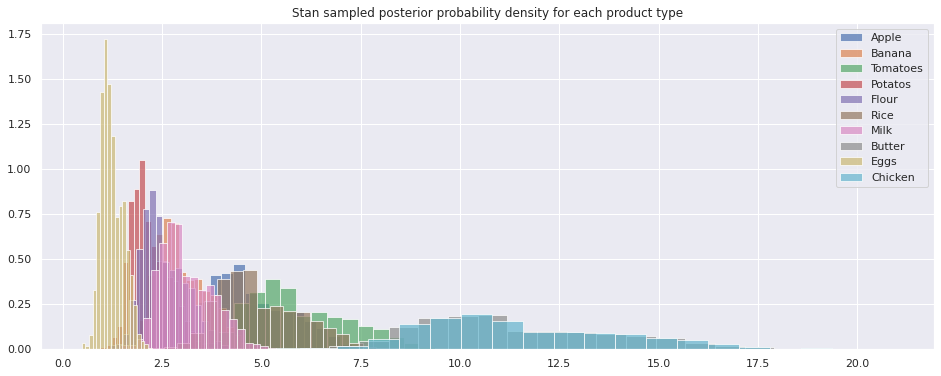

,Product,Mean,Posterior 95% confidence interval,Standard Error
0,Apple,4.76,"[3.210367424366704, 6.898511826198471]",1.01
1,Banana,2.99,"[2.0142869040290114, 4.317723952373564]",0.63
2,Tomatoes,5.93,"[4.002428599109989, 8.575678305296535]",1.26
3,Potatos,2.18,"[1.4557740158399575, 3.19877157596035]",0.47
4,Flour,2.53,"[1.7089816178404063, 3.7135383960785466]",0.55
5,Rice,4.96,"[3.347033728282342, 7.155632914767381]",1.05
6,Milk,3.10,"[2.0782721569942924, 4.493235145000916]",0.66
7,Butter,11.38,"[7.641702565669637, 16.44728832529275]",2.42
8,Eggs,1.24,"[0.811293718042704, 1.8267072995025995]",0.28
9,Chicken,11.56,"[7.76582062589005, 16.678139465173505]",2.46


In [158]:
#creating a dataframe to store the information of the posterior probability density function for each product
product_df = pd.DataFrame(columns=['Product','Mean','Posterior 95% confidence interval','Standard Error'])

#plotting the porsterior probability density function
plt.figure(figsize = (16,6))
plt.title('Stan sampled posterior probability density for each product type')
for i in range(len(product_list)):
    plt.hist(posterior['base_price'][:,i],bins=20, density=True, alpha = 0.7, label = product_list[i+1])
    #stroring the data in the product_df dataframe
    product_df.loc[i] = (product_list[i+1],
                      round(np.mean(posterior['base_price'][:,i]),2),
                      np.percentile(posterior['base_price'][:,i], [2.5, 97.5]),
                      round(np.std(posterior['base_price'][:,i], ddof=1),2))
plt.legend()
plt.show()

product_df

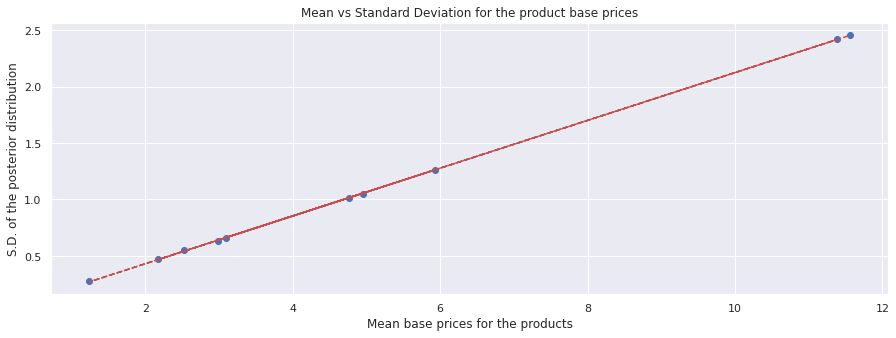

In [184]:
#plotting the correlation between mean and standard deviation
x = product_df['Mean']
y = product_df['Standard Error']
plt.figure(figsize=(15,5))
plt.xlabel("Mean base prices for the products")
plt.ylabel("S.D. of the posterior distribution")
plt.title("Mean vs Standard Deviation for the product base prices")
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()

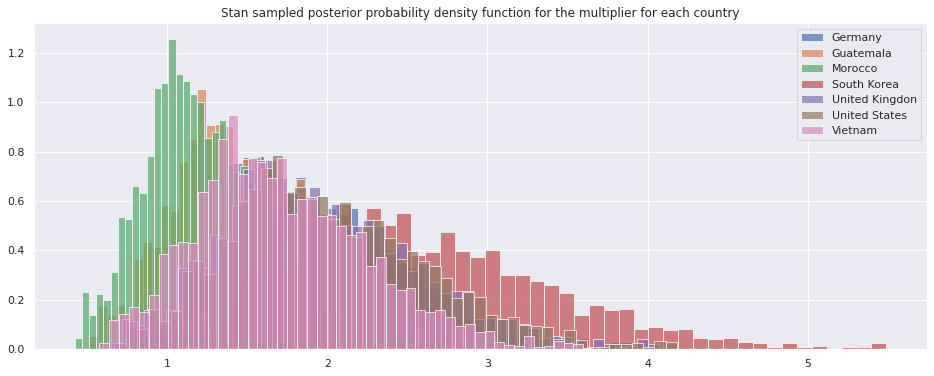

,Country,Mean,Posterior 95% confidence interval,Standard Error
0,Germany,1.86,"[0.8682519575825315, 3.1195541939938525]",0.58
1,Guatemala,1.51,"[0.7027996448259881, 2.5441870456853537]",0.47
2,Morocco,1.25,"[0.5932956470797992, 2.107161782974449]",0.39
3,South Korea,2.57,"[1.2043933654857204, 4.325199451897673]",0.80
4,United Kingdon,1.95,"[0.9134532985798541, 3.28750826548653]",0.61
5,United States,2.01,"[0.9403199115561663, 3.375352150683729]",0.62
6,Vietnam,1.71,"[0.8027706301848513, 2.8909374116557838]",0.53


In [162]:
#creating a dataframe to store the information of the posterior probability density function for the multiplier each country
country_df = pd.DataFrame(columns=['Country','Mean','Posterior 95% confidence interval','Standard Error'])

#plotting the porsterior probability density function
plt.figure(figsize = (16,6))
plt.title('Stan sampled posterior probability density function for the multiplier for each country')
for i in range(len(set(countries))):
    plt.hist(posterior['country_multiplier'][:,i],bins=50, density=True, alpha = 0.7, label = country_list[i+1]) 
    #stroring the data in the country_df dataframe
    country_df.loc[i] = (country_list[i+1],
                       round(np.mean(posterior['country_multiplier'][:,i]),2),
                       np.percentile(posterior['country_multiplier'][:,i], [2.5, 97.5]),
                       round(np.std(posterior['country_multiplier'][:,i], ddof=1),2))
plt.legend()
plt.show()
country_df

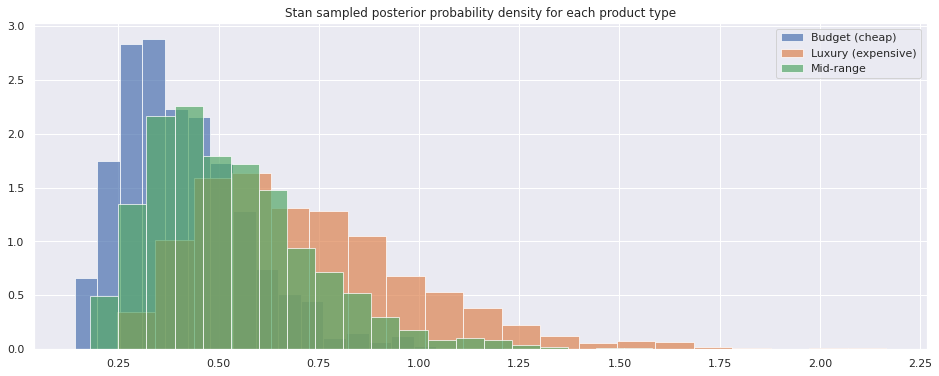

,Brand Perception,Mean,Posterior 95% confidence interval,Standard Error
0,Budget (cheap),0.41,"[0.19120959439160407, 0.8015784704247764]",0.16
1,Luxury (expensive),0.72,"[0.33258542216280257, 1.396995594944184]",0.28
2,Mid-range,0.53,"[0.24355941476605325, 1.0166331530559611]",0.20


In [163]:
#creating a dataframe to store the information of the posterior probability density function for the multiplier of different store trypes (bran perception)
store_type_df = pd.DataFrame(columns=['Brand Perception','Mean','Posterior 95% confidence interval','Standard Error'])

#plotting the porsterior probability density function
plt.figure(figsize = (16,6))
plt.title('Stan sampled posterior probability density for each product type')
for i in range(len(set(types))):
    plt.hist(posterior['store_multiplier'][:,i],bins=20, density=True, alpha = 0.7, label = type_list[i+1])
    #stroring the data in the product_df dataframe
    store_type_df.loc[i] = (type_list[i+1],
                      round(np.mean(posterior['store_multiplier'][:,i]),2),
                      np.percentile(posterior['store_multiplier'][:,i], [2.5, 97.5]),
                      round(np.std(posterior['store_multiplier'][:,i], ddof=1),2))
plt.legend()
plt.show()
store_type_df

In [176]:
country_df[['Country','Mean']]

#the prices were collected from the main dataset and averaged out for a 70 m^2 apartment
Germany = [900,850,1000,1000,895,1002,1128,955,925,915,1090,1150,955,1905,1500,1027,895,865,863,1044,926.5,955]
Guatemala = [2333, 4872.65]
Morocco = [7960,7960,15000,6000]
South_Korea = [530000]
United_Kingdom = [1300,1300,2080,1750,1300,1640,2080,1950,1755]
United_States = [3684,3871,4389.7,3904.6,1500,1500,2860,2395,362.6,1107,2450,2600,1800,1200]
Vietnam = [1500,500,500]

#the prices are averaged out and normalized to USD
avg_rental_prices = [np.mean(Germany)*1.185,np.mean(Guatemala)*0.128,np.mean(Morocco)*0.109,np.mean(South_Korea)*0.0009,np.mean(United_Kingdom)*1.323,
                 np.mean(United_States), np.mean(Vietnam)]

price_compare = country_df[['Country','Mean']]
price_compare['Rental price means'] = np.round(avg_rental_prices,2)
price_compare

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Country,Mean,Rental price means
0,Germany,1.86,1225.16
1,Guatemala,1.51,461.16
2,Morocco,1.25,1006.07
3,South Korea,2.57,477.00
4,United Kingdon,1.95,2227.78
5,United States,2.01,2401.71
6,Vietnam,1.71,833.33


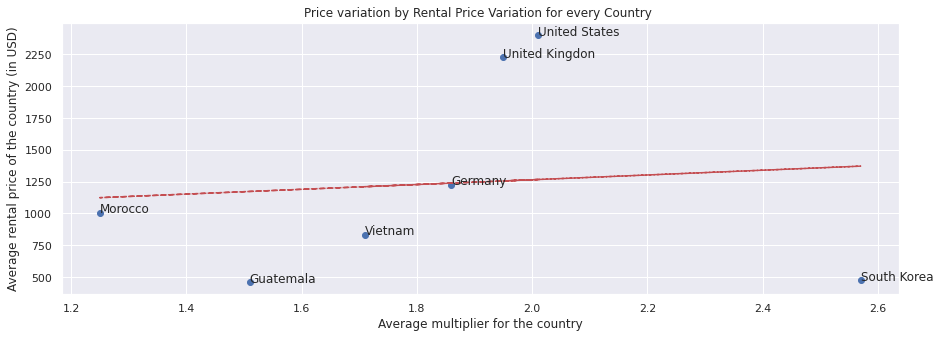

In [185]:
x = price_compare['Mean']
y = price_compare['Rental price means']
plt.figure(figsize=(15,5))
plt.scatter(x, y)
country_names = [i for j,i in country_list.items()]

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.xlabel("Average multiplier for the country")
plt.ylabel("Average rental price of the country (in USD)")
plt.title("Price variation by Rental Price Variation for every Country ")
plt.plot(x,p(x),"r--")

for i, j in enumerate(country_names):
    plt.annotate(j, (x[i], y[i]))

plt.show()